<a href="https://colab.research.google.com/github/zhenghaojiang/DSGE/blob/main/Value_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# rouwen
def rouwen(rho, mu, step, num):
    # discrete state space
    dscSp = np.linspace(mu -(num-1)/2*step, mu +(num-1)/2*step, num).T

    # transition probability matrix
    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
              [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
              [(1-p)**2, (1-p)*q, q**2]]).T


    while transP.shape[0] <= num - 1:

        # see Rouwenhorst 1995
        len_P = transP.shape[0]
        transP = p * np.vstack((np.hstack((transP, np.zeros((len_P, 1)))), np.zeros((1, len_P+1)))) \
                + (1 - p) * np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
                + (1 - q) * np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
                + q * np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.


    # ensure columns sum to 1
    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return transP.T, dscSp

In [3]:
r = 1/0.96 - 1
theta = 0.70
delta = 0.15
rho = 0.70
k_st = (((r+delta)*(1+0.01*delta)-0.005*(delta**2))/theta) ** (1/(theta-1))
I_st = delta*k_st
sigma = 0.15

def modeldefs(k, kp):
  I = kp-(1-delta)*k
  return I
def funcpi(k, z):
  x = z*k**theta
  return x
def funcpsi(I, k):
  x = 0.01*(I**2)/(2*k)
  return x

In [4]:
# set up grid for k
keps = .01
klow = keps*k_st
khigh = (2-keps)*k_st
knpts = 51
kgrid = np.linspace(klow, khigh, num = knpts)

# set up Markov approximation of AR(1) process using Rouwenhorst method
spread = 2.  # number of standard deviations above and below 0
znpts = 16
zstep = 2*spread*sigma/(znpts-1)
# Markov transition probabilities, current z in cols, next z in rows
Pimat, lnzgrid = rouwen(rho, 0., zstep, znpts)
zgrid = np.exp(lnzgrid)

VF = np.zeros((knpts, znpts))
VFnew = np.zeros((knpts, znpts))
PF = np.zeros((knpts, znpts))

ccrit = 1.0E-2
maxit = 1000
damp = 1.
dist = 1.0E+99
iters = 0

In [5]:
while (dist > ccrit) and (iters < maxit):
    VFnew.fill(0.0)
    iters = iters + 1
    for i in range (0, knpts):
        for j in range(0, znpts):
            maxval = -1.0E+98
            for m in range(0, knpts):
                # get current period utility
                I = modeldefs(kgrid[i], kgrid[m])
                # get expected value
                val = funcpi(kgrid[i], zgrid[j]) - funcpsi(I, kgrid[i]) - I
                for n in range (0, znpts):
                    # sum over all possible value of z(t+1) with Markov probs
                    val = val + Pimat[n, j]*VF[m, n]/(1+r)
                    # if this exceeds previous maximum do replacements
                if val > maxval:
                    maxval = val
                    VFnew[i, j] = val
                    PF[i, j] = kgrid[m]
    dist = np.amax(np.abs(VF - VFnew))
    print('iteration: ', iters, 'distance: ', dist)
    VF = damp*VFnew + (1-damp)*VF

iteration:  1 distance:  170.01999552952046
iteration:  2 distance:  12.022597147589437
iteration:  3 distance:  9.51239266402763
iteration:  4 distance:  7.906627149013957
iteration:  5 distance:  6.848901069758568
iteration:  6 distance:  6.114907804248219
iteration:  7 distance:  5.578300985196108
iteration:  8 distance:  5.166690090654157
iteration:  9 distance:  4.836893166585213
iteration:  10 distance:  4.562295917637073
iteration:  11 distance:  4.326042445100768
iteration:  12 distance:  4.11722348287222
iteration:  13 distance:  3.928656022528628
iteration:  14 distance:  3.755540077158088
iteration:  15 distance:  3.594622757519261
iteration:  16 distance:  3.443667177458167
iteration:  17 distance:  3.3011097112145364
iteration:  18 distance:  3.165836195032739
iteration:  19 distance:  3.037034519503834
iteration:  20 distance:  2.9140969104506667
iteration:  21 distance:  2.7965548345159164
iteration:  22 distance:  2.6840354725121074
iteration:  23 distance:  2.576232521

In [6]:
print('Converged after', iters, 'iterations')
print('Policy function at (', int((knpts-1)/2), ',', int((znpts-1)/2), ') should be', \
    kgrid[int((knpts-1)/2)], 'and is', PF[int((knpts-1)/2), int((znpts-1)/2)])

Converged after 159 iterations
Policy function at ( 25 , 7 ) should be 74.79117175544732 and is 71.82944135393161


In [7]:
def policy(k,z):
  i = np.argmin(abs(kgrid-k))
  j = np.argmin(abs(zgrid-z))
  k_new = PF[i,j]
  return k_new

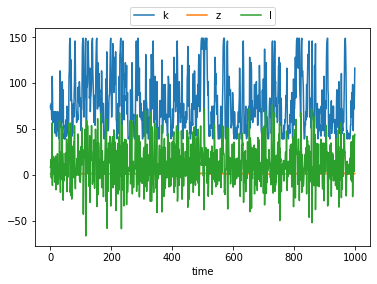

In [8]:
# perform simulation
T = 1000  # number of periods to simulate
kstart = k_st # starting value for simulation
# initialize variable histories
epshist = np.random.randn(T)*sigma
khist= np.zeros(T+1)
zhist = np.ones(T+1)
Ihist = np.zeros(T)
khist[0] = kstart
for t in range(0, T):
    # perform simulation with polynomial fit
    khist[t+1] = policy(khist[t],zhist[t])
    zhist[t+1] = (zhist[t]**rho)*np.exp(epshist[t])
    Ihist[t] = modeldefs(khist[t], khist[t+1])   
# remove final k & z
khist = khist[0:T]
zhist = zhist[0:T]

# plot data
t = range(0, T)
plt.plot(t, khist, label='k')
plt.plot(t, zhist, label='z')
plt.plot(t, Ihist, label='I')
plt.xlabel('time')
plt.legend(loc=9, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()